In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import yfinance as yf

In [2]:
# List of stock tickers to download
tickers = ['FZILX', 'FZROX', 'FXNAX']

# Download data for the given tickers and time period
data = yf.download(tickers, period='1y', progress=False, group_by='ticker')

# Reset index to bring Date into the columns
etf_data = data.stack(level=0, future_stack=True).reset_index()

etf_data.head()  

Price,Date,Ticker,Open,High,Low,Close,Volume
0,2024-01-17,FXNAX,9.957603,9.957603,9.957603,9.957603,0
1,2024-01-17,FZILX,10.349253,10.349253,10.349253,10.349253,0
2,2024-01-17,FZROX,16.267395,16.267395,16.267395,16.267395,0
3,2024-01-18,FXNAX,9.938268,9.938268,9.938268,9.938268,0
4,2024-01-18,FZILX,10.426993,10.426993,10.426993,10.426993,0


In [3]:
etf_data['Daily Return'] = etf_data.groupby('Ticker')['Close'].pct_change()
daily_returns = etf_data.pivot_table(index='Date', columns='Ticker', values='Daily Return')
daily_returns

Ticker,FXNAX,FZILX,FZROX
Date,,,
2024-01-18,-0.001942,0.007512,0.008511
2024-01-19,0.000000,0.004660,0.012056
2024-01-22,0.001946,0.000000,0.004169
2024-01-23,-0.001942,0.000928,0.001779
2024-01-24,-0.002918,0.007414,0.000000
...,...,...,...
2025-01-10,-0.004921,-0.016652,-0.015115
2025-01-13,-0.001978,-0.004456,0.001485
2025-01-14,0.000000,0.006267,0.002472


In [4]:
mean_returns = ((1 + daily_returns.mean())**252) -1
mean_returns

Ticker
FXNAX    0.025978
FZILX    0.112139
FZROX    0.280408
dtype: float64

In [5]:
cov_matrix = np.cov(daily_returns, rowvar=False) * (252)
#daily_returns.cov() * (252)
cov_matrix

array([[0.00301001, 0.00184335, 0.00100025],
       [0.00184335, 0.01493216, 0.01184606],
       [0.00100025, 0.01184606, 0.01734797]])

In [6]:
# Function to calculate portfolio performance
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_std


In [7]:
# Generate random portfolio weights
num_portfolios = 5000
results = np.zeros((3, num_portfolios))  # Rows: return, std, sharpe_ratio
weights_record = []


for i in range(num_portfolios):
    weights = np.random.random(3)
    weights /= np.sum(weights)  # Normalize weights to sum to 1
    weights_record.append(weights)
    ret, std = portfolio_performance(weights, mean_returns, cov_matrix)
    sharpe_ratio = ret / std
    results[0, i] = ret
    results[1, i] = std
    results[2, i] = sharpe_ratio

In [8]:
# Extract optimal portfolios
max_sharpe_idx = np.argmax(results[2])  # Max Sharpe Ratio
min_vol_idx = np.argmin(results[1])  # Minimum Volatility

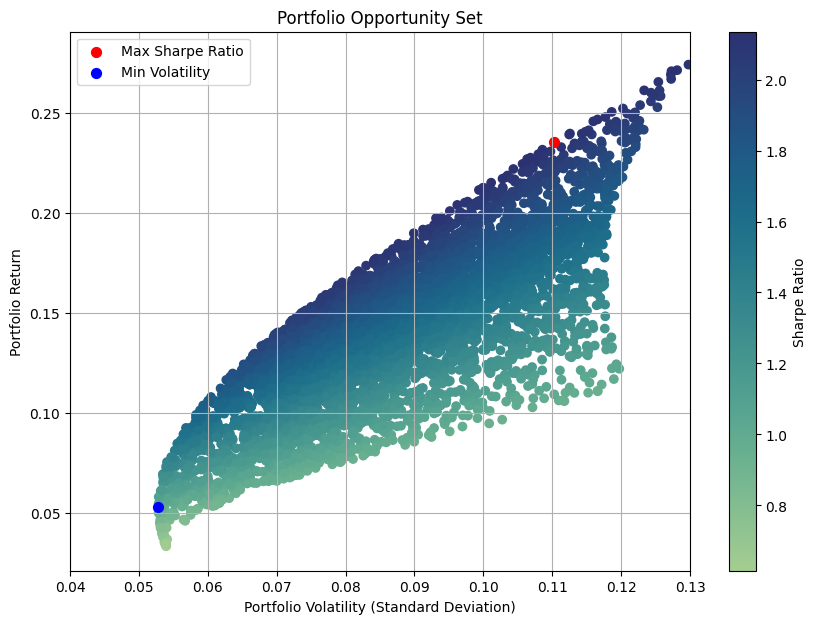

In [15]:
# Plot opportunity set
plt.figure(figsize=(10, 7))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='crest', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], color='red', label='Max Sharpe Ratio', s=50)
plt.scatter(results[1, min_vol_idx], results[0, min_vol_idx], color='blue', label='Min Volatility', s=50)
plt.title('Portfolio Opportunity Set')
plt.xlabel('Portfolio Volatility (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.legend()
plt.xlim(xmin=0.04, xmax=0.13)
plt.grid(True)
plt.show()

In [10]:
# Get optimal weights
max_sharpe_weights = weights_record[max_sharpe_idx]
min_vol_weights = weights_record[min_vol_idx]

# Display parameters of optimal portfolios
print("Portfolio with Maximum Sharpe Ratio:")
print(f"Weights: {max_sharpe_weights}")
print(f"Expected Return: {results[0, max_sharpe_idx]:.4f}")
print(f"Volatility (Standard Deviation): {results[1, max_sharpe_idx]:.4f}")
print(f"Sharpe Ratio: {results[2, max_sharpe_idx]:.4f}\n")

print("Portfolio with Minimum Volatility:")
print(f"Weights: {min_vol_weights}")
print(f"Expected Return: {results[0, min_vol_idx]:.4f}")
print(f"Volatility (Standard Deviation): {results[1, min_vol_idx]:.4f}")
print(f"Sharpe Ratio: {results[2, min_vol_idx]:.4f}\n")

Portfolio with Maximum Sharpe Ratio:
Weights: [0.17480713 0.00247866 0.82271421]
Expected Return: 0.2355
Volatility (Standard Deviation): 0.1103
Sharpe Ratio: 2.1347

Portfolio with Minimum Volatility:
Weights: [0.89148426 0.00403382 0.10448192]
Expected Return: 0.0529
Volatility (Standard Deviation): 0.0528
Sharpe Ratio: 1.0014



In [11]:
mean_returns

Ticker
FXNAX    0.025978
FZILX    0.112139
FZROX    0.280408
dtype: float64

In [12]:
standard_deviation = daily_returns.std() * np.sqrt(252)
standard_deviation

Ticker
FXNAX    0.054864
FZILX    0.122197
FZROX    0.131712
dtype: float64

In [13]:
optimal_parameters = pd.DataFrame({
    'Ticker': mean_returns.index,
    'Weights': max_sharpe_weights
})
print('Optimal Portfolio Weights:')
optimal_parameters

Optimal Portfolio Weights:


,Ticker,Weights
0,FXNAX,0.174807
1,FZILX,0.002479
2,FZROX,0.822714
